In [1]:
# reloading modules if needed
from importlib import reload

# first import the whole package
import PyPolyCrystals

# then (re)load all the functions in the .py files in the .../PyPolyCrystals/ directory:
from PyPolyCrystals import *
reload(PyPolyCrystals)
from PyPolyCrystals import *

In [2]:
import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)
#torch.set_default_device(device)

In [3]:
# NEW EXAMPLE with input from MTEX

file = "../../data/2D_Tata_Steel_new_example/sample_lc_steel_grain_file_MTEX4.txt"
seed_id = (0,1)
volumes_id = (5)
orientation_id = (2,3,4)

X, A, TV, EBSD = load_setup_from_EBSD_data_2D(file = file,
                                             seed_id = seed_id,
                                             volumes_id = volumes_id,
                                             orientation_id = orientation_id,
                                             normalise_matrices = True,
                                             angle_in_degrees = False,
                                             device = device,
                                             dt = dt)
X = X.to(device,dtype=dt)
A = A.to(device,dtype=dt)
TV = TV.to(device,dtype=dt)
N, D = X.shape
#M=4000

In [4]:
dom_x = [-998.777,0.25]
dom_y = [-900.75,0.25]
domain = torch.tensor([dom_x,dom_y])
domain

tensor([[-9.9877700000e+02,  2.5000000000e-01],
        [-9.0075000000e+02,  2.5000000000e-01]])

In [5]:
len_x = dom_x[1] - dom_x[0]
len_y = dom_y[1] - dom_y[0]
len_x

999.027

In [6]:
total_area = TV.sum()
print("Largest grain: ", torch.max(TV).cpu().numpy(), "Smallest grain: ",torch.min(TV).cpu().numpy())
#print("Largest grain: ", torch.max(TV).cpu().numpy(), ". Smallest grain: ",torch.min(TV).cpu().numpy()),# ". Ratio: ",(torch.max(TV)/torch.min(TV)).cpu().numpy())

Largest grain:  2592.47589751824 Smallest grain:  12.7503425327633


In [7]:
total_area / len_y

tensor(999.4450698752, device='cuda:0')

In [8]:
len_x

999.027

In [9]:
len_x * len_y

900123.327

In [10]:
apd1 = apd_system(D=2,
                  domain = domain,
                  X = X,
                  As = A,
                  heuristic_W = True, # the default set of weights is the heuristic guess!
                  target_masses = TV/total_area,
                  dt = torch.float64,
                  device = device,
                  pixel_size_prefactor = 1.0,
                  error_tolerance = 0.01
                  )

In [11]:
apd1.N

3890

In [12]:
apd1.pixel_params

(2657, 2657)

In [13]:
W_heuristic = copy.deepcopy(apd1.W)

In [14]:
img = apd1.assemble_apd(color_by = EBSD[:,-3:])
img2 = img.reshape(apd1.pixel_params + (3,)).transpose(0,1).cpu()

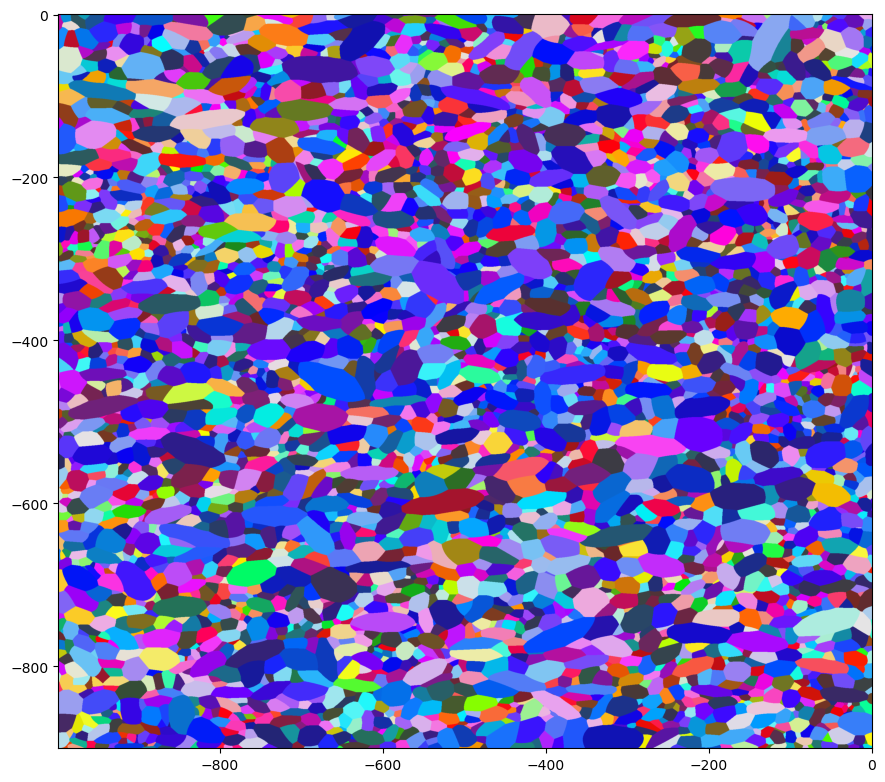

In [15]:
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(10.5, 10.5, forward=True)
ax1.imshow(img2, origin='lower', extent = torch.flatten( apd1.domain ).tolist())
#ax1.invert_yaxis()
#ax1.invert_xaxis()

In [17]:
# but the error is still huge:
Dg, error = apd1.check_optimality(return_gradient_and_error=True)

Precision loss detected!
Percentage error =  530.6195161032401


In [18]:
# and now solve the OT problem to get optimal weights:
apd1.set_W(W=torch.zeros(apd1.N).to(device=apd1.device,dtype=apd1.dt))
apd1.optimality = False
apd1.check_optimality()
apd1.find_optimal_W()

Precision loss detected!
Percentage error =  2498.9786372697185
Solver tolerance is with respect to each grain separately.
Smallest tol:  tensor(0.1274500904, device='cuda:0')
Optimality condition successfully overwritten.
Optimization terminated successfully.
         Current function value: -81013122.710831
         Iterations: 590
         Function evaluations: 1100
It took 101.46143984794617 seconds to find optimal W.


In [19]:
apd1.check_optimality()

The APD is optimal!
Percentage error =  0.9015261289113335


In [20]:
W_optimal = copy.deepcopy(apd1.W)

In [24]:
#apd1.set_pixel_params(pixel_params = (1998,1802))

In [25]:
#apd1.assemble_pixels()

In [27]:
#apd1.Y[-1]

tensor([-0.0273534148,  0.0244116174], device='cuda:0')

In [21]:
apd1.domain[1,1]

tensor(0.2500000000, device='cuda:0')

In [22]:
(apd1.domain[1,1] - apd1.domain[1,0] + 0.5) / 0.5

tensor(1803., device='cuda:0')

In [23]:
apd1.domain[1,0]

tensor(-900.7500000000, device='cuda:0')

In [24]:
apd1.domain[1,1]

tensor(0.2500000000, device='cuda:0')

In [25]:
# first rectangular grid:
i = 0
grid_x = torch.linspace(apd1.domain[i,0] + 0.25, apd1.domain[i,1] - 0.25, 1998)

i = 1
grid_y = torch.linspace(apd1.domain[i,0] + 0.25, apd1.domain[i,1] - 0.25, 1802)

mesh1 = torch.meshgrid((grid_x,grid_y), indexing="ij") if apd1.D == 2 else torch.meshgrid((grid_x,grid_y,grid_z), indexing="ij")
pixels1 = torch.stack(mesh1, dim=-1).to(device=apd1.device,dtype=apd1.dt)
pixels1b = pixels1.reshape(-1, apd1.D)

In [26]:
apd1.domain[1,0]+0.25

tensor(-900.5000000000, device='cuda:0')

In [27]:
apd1.domain[1,1] - 0.25

tensor(0., device='cuda:0')

In [28]:
grid_x[2]

tensor(-997.5269729594)

In [29]:
grid_y[1]

tensor(-900.)

In [30]:
apd1.domain[0,0]

tensor(-998.7770000000, device='cuda:0')

In [31]:
pixels = pixels1b
PS = 1.0/4.0 * torch.ones(pixels.shape[0])

In [32]:
len(pixels)

3600396

In [33]:
PS.sum()

tensor(900099.)

In [34]:
total_area

tensor(900500.0079575491, device='cuda:0')

In [35]:
apd1.Y = pixels.to(device=apd1.device, dtype=apd1.dt)
apd1.PS = PS.to(device=apd1.device, dtype=apd1.dt)

In [36]:
apd1.Y.view(1,apd1.Y.shape[0],apd1.D).shape

torch.Size([1, 3600396, 2])

In [37]:
apd1.y = LazyTensor(apd1.Y.view(1,apd1.Y.shape[0],apd1.D))

In [38]:
Dg, error = apd1.check_optimality(return_gradient_and_error=True)

Precision loss detected!
Percentage error =  11.793428709804438


In [39]:
apd1.set_W(W = W_optimal)
img_optimal = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_heuristic)
img_heuristic = copy.deepcopy(apd1.assemble_apd())

diff_opt_heu = sum(torch.abs(img_heuristic - img_optimal) > 0.5)

diff_opt_heu / img_optimal.shape[0]

tensor(0.0567457024, device='cuda:0')

In [107]:
#diff_opt_heu / img_optimal.shape[0]

tensor(0., device='cuda:0')

In [63]:
My_pixel_data = torch.cat((apd1.Y,img_optimal[...,None]), 1)

My_pixel_data.device

file = "../../data/2D_Tata_Steel_new_example/grainIDs5.txt"

EBSD_pixel_data = torch.from_numpy(np.loadtxt(file)).to(device=apd1.device, dtype=apd1.dt)

EBSD_pixel_data.shape

EBSD_pixel_data[:,1].min()

My_pixel_data[:,1].min()

EBSD_pixel_data[:,0].min()

My_pixel_data[:,0].min()

EBSD_pixel_data[:,0].max()



EBSD_pixel_data.shape

#sorted, II = torch.sort(EBSD_pixel_data[:,0])

#EBSD_pixel_data[II,:]

#sorted, II = torch.sort(My_pixel_data[:,0])
#My_pixel_data[II,:]

torch.Size([3587394, 6])

In [41]:
My_pixel_data.shape

torch.Size([3600396, 3])

In [42]:
My_pixel_data[:,1].min()

tensor(-900.5000000000, device='cuda:0')

In [43]:
EBSD_pixel_data[:,1].min()

tensor(-900.5000000000, device='cuda:0')

In [44]:
(torch.norm(EBSD_pixel_data[:,0:2][1] - My_pixel_data[:,0:2],dim=1) < 0.1).nonzero()

tensor([[3]], device='cuda:0')

In [45]:
EBSD_pixel_data[:,0:2][1]

tensor([-998.5270000000, -899.0000000000], device='cuda:0')

In [46]:
My_pixel_data[:,0:2][3]

tensor([-998.5270000000, -899.0000000000], device='cuda:0')

In [47]:
II = [(torch.norm(EBSD_pixel_data[:,0:2][i] - My_pixel_data[:,0:2],dim=1) < 0.1).nonzero().item() for i in range(EBSD_pixel_data.shape[0]) ]

In [48]:
# II[0]

# My_pixel_data[II,:]

# EBSD_pixel_data

# My_pixel_data[:,2].max()

# EBSD_pixel_data[:,2].max()

# My_pixel_data[:,2].min()

# EBSD_pixel_data[:,2].min()

#mismatch = My_pixel_data[II,2] - EBSD_pixel_data[:,2] + 1
mismatch_optimal = img_optimal[II] - EBSD_pixel_data[:,2] + 1
mismatch_heuristic = img_heuristic[II] - EBSD_pixel_data[:,2] + 1

diff_optimal_ebsd = sum(torch.abs(mismatch_optimal) > 0.5)
diff_heuristic_ebsd = sum(torch.abs(mismatch_heuristic) > 0.5)

In [49]:
diff_optimal_ebsd /EBSD_pixel_data.shape[0]

tensor(0.9997340930, device='cuda:0')

In [50]:
diff_heuristic_ebsd /EBSD_pixel_data.shape[0]

tensor(0.9997705301, device='cuda:0')

In [51]:
diff_optimal_ebsd

tensor(3594286, device='cuda:0')

In [53]:
My_pixel_data[II,:]

tensor([[-9.9852700000e+02, -8.9950000000e+02,  4.1000000000e+01],
        [-9.9852700000e+02, -8.9900000000e+02,  4.1000000000e+01],
        [-9.9852700000e+02, -8.9850000000e+02,  4.1000000000e+01],
        ...,
        [ 0.0000000000e+00, -1.0000000000e+00,  3.8890000000e+03],
        [ 0.0000000000e+00, -5.0000000000e-01,  3.8890000000e+03],
        [ 0.0000000000e+00,  0.0000000000e+00,  3.8890000000e+03]],
       device='cuda:0')

In [56]:
EBSD_pixel_data[:,0:3]

tensor([[-9.9852700000e+02, -8.9950000000e+02,  5.4000000000e+01],
        [-9.9852700000e+02, -8.9900000000e+02,  5.4000000000e+01],
        [-9.9852700000e+02, -8.9850000000e+02,  5.4000000000e+01],
        ...,
        [ 0.0000000000e+00, -1.0000000000e+00,  4.1690000000e+03],
        [ 0.0000000000e+00, -5.0000000000e-01,  4.1690000000e+03],
        [ 0.0000000000e+00,  0.0000000000e+00,  4.1690000000e+03]],
       device='cuda:0')

In [64]:
EBSD_pixel_data[:,2].max()

tensor(3890., device='cuda:0')

In [67]:
My_pixel_data[:,2].max()

tensor(3889., device='cuda:0')

In [20]:
apd1.error_tolerance = 0.001
apd1.set_pixel_params()
apd1.assemble_pixels()
apd1.pixel_params

(9724, 9724)

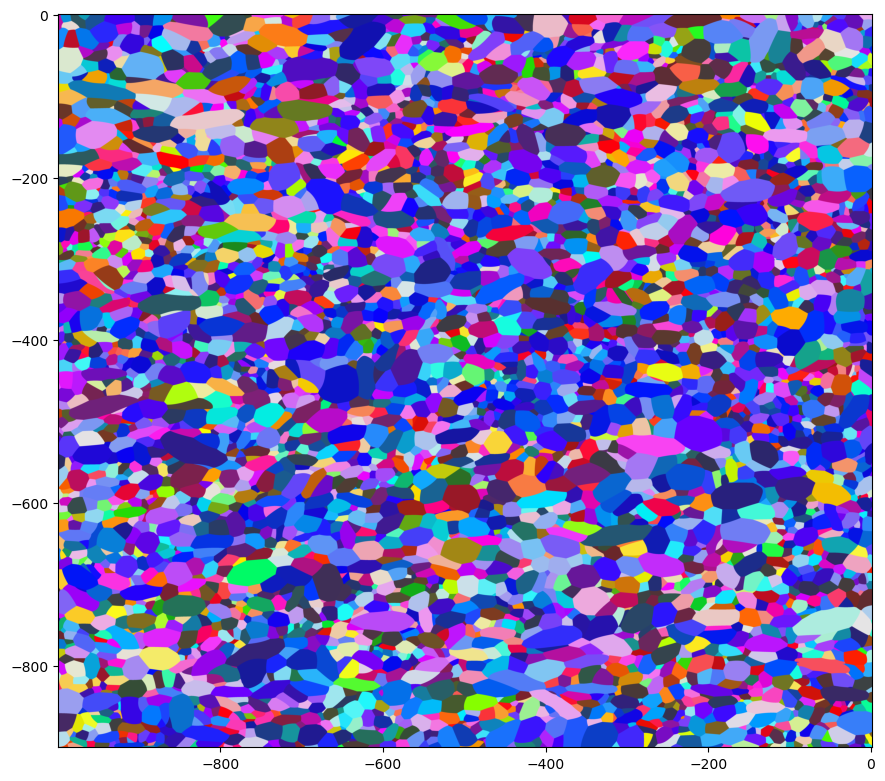

In [21]:
#fig, ax1 = apd1.plot_apd(color_by = EBSD[:,orientation_id[-1]])
img = apd1.assemble_apd(color_by = EBSD[:,-3:])
img2 = img.reshape(apd1.pixel_params + (3,)).transpose(0,1).cpu()
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(10.5, 10.5, forward=True)
ax1.imshow(img2, origin='lower', extent = torch.flatten( apd1.domain ).tolist())
#ax1.invert_yaxis()
#ax1.invert_xaxis()

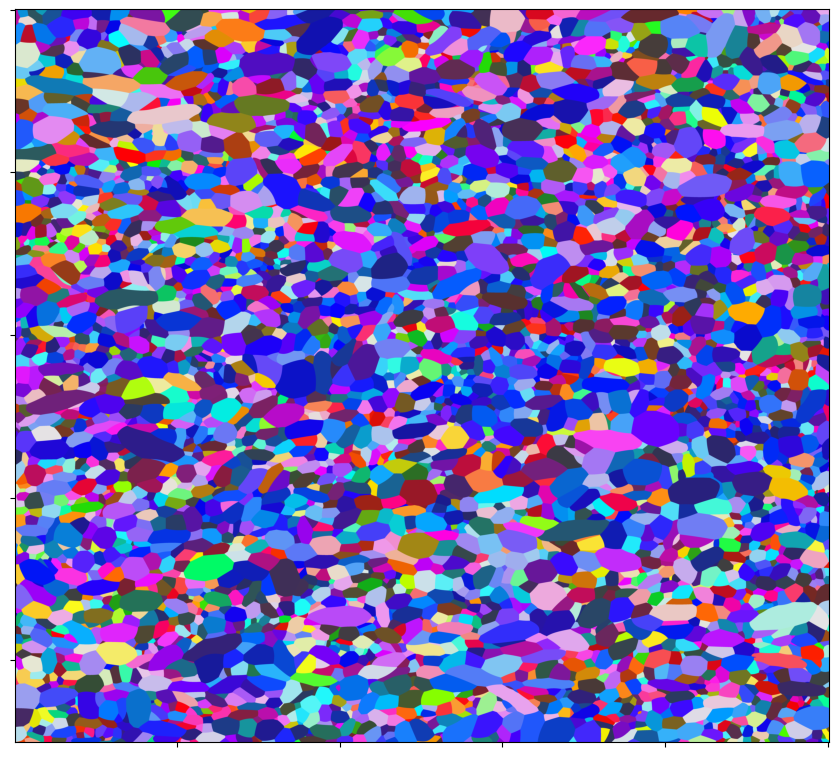

In [22]:
ax1.set_xticklabels([])
ax1.set_yticklabels([])

fig.savefig('new_example_ipf.pdf')
fig

In [21]:
#img_optimal = apd1.assemble_apd()

In [22]:
#img_optimal.shape

In [23]:
#apd1.Y.shape

In [24]:
# first rectangular grid:
i = 1
grid_y = torch.linspace(apd1.domain[i,0] + 0.5, apd1.domain[i,1] - 0.5, 901)

L1 = int(1154/2)

i = 0
grid_x = torch.linspace(apd1.domain[i,0] + 1.0 + np.sqrt(3)/2, apd1.domain[i,1] - 1.0, L1)

mesh1 = torch.meshgrid((grid_x,grid_y), indexing="ij") if apd1.D == 2 else torch.meshgrid((grid_x,grid_y,grid_z), indexing="ij")
pixels1 = torch.stack(mesh1, dim=-1).to(device=apd1.device,dtype=apd1.dt)
pixels1b = pixels1.reshape(-1, apd1.D)

In [25]:
pixels1b[:,0].min()

tensor(-997.6612545962, device='cuda:0')

In [26]:
pixels1b[:,1].min()

tensor(-900., device='cuda:0')

In [27]:
apd1.domain[0,1]

tensor(1., device='cuda:0')

In [28]:
# second rectangular grid:
i = 1
grid_y = torch.linspace(apd1.domain[i,0] + 1.0, apd1.domain[i,1] - 1.0, 900)

L1 = int(1154/2)

i = 0
grid_x = torch.linspace(apd1.domain[i,0] + 1.0, apd1.domain[i,1] - 1.0 - np.sqrt(3)/2, L1)

mesh2 = torch.meshgrid((grid_x,grid_y), indexing="ij") if apd1.D == 2 else torch.meshgrid((grid_x,grid_y,grid_z), indexing="ij")
pixels2 = torch.stack(mesh2, dim=-1).to(device=apd1.device,dtype=apd1.dt)
pixels2b = pixels2.reshape(-1, apd1.D)

In [29]:
(pixels1b.shape[0] + pixels2b.shape[0]) 

1039177

In [30]:
pixels2b[-1]

tensor([-0.8660254038, -0.5000000000], device='cuda:0')

In [31]:
pixels = torch.cat((pixels1b,pixels2b))
PS = np.sqrt(3.0)/2.0 * torch.ones(pixels.shape[0])

In [32]:
PS.sum()

tensor(899953.6810285023)

In [33]:
pixels[-1]

tensor([-0.8660254038, -0.5000000000], device='cuda:0')

In [34]:
apd1.Y = pixels.to(device=apd1.device, dtype=apd1.dt)
apd1.PS = PS.to(device=apd1.device, dtype=apd1.dt)

In [35]:
apd1.Y.view(1,apd1.Y.shape[0],apd1.D).shape

torch.Size([1, 1039177, 2])

In [36]:
apd1.y = LazyTensor(apd1.Y.view(1,apd1.Y.shape[0],apd1.D))

In [37]:
Dg, error = apd1.check_optimality(return_gradient_and_error=True)

Precision loss detected!
Percentage error =  55.82022000707071


In [ ]:
# the above does not really mean much because of the discrepancies at the boundary

In [38]:
W_optimal = copy.deepcopy(apd1.W)

apd1.set_W(W = W_optimal)

img_optimal = copy.deepcopy(apd1.assemble_apd())

W_heuristic

apd1.set_W(W = W_heuristic)

apd1.W

img_heuristic = copy.deepcopy(apd1.assemble_apd())

img_optimal.shape

diff_opt_heu = sum(torch.abs(img_heuristic - img_optimal) > 0.5)

diff_opt_heu / img_optimal.shape[0]

img_optimal.max()

apd1.Y.shape

img_optimal.shape

In [51]:
My_pixel_data = torch.cat((apd1.Y,img_optimal[...,None]), 1)

My_pixel_data.device

file = "../../data/2D_Tata_Steel_new_example/grainIDs.txt"

EBSD_pixel_data = torch.from_numpy(np.loadtxt(file)).to(device=apd1.device, dtype=apd1.dt)

EBSD_pixel_data.shape

EBSD_pixel_data[:,1].min()

My_pixel_data[:,1].min()

EBSD_pixel_data[:,0].min()

My_pixel_data[:,0].min()

EBSD_pixel_data[:,0].max()

My_pixel_data[:,0].max()

My_pixel_data.shape

EBSD_pixel_data.shape

#sorted, II = torch.sort(EBSD_pixel_data[:,0])

#EBSD_pixel_data[II,:]

#sorted, II = torch.sort(My_pixel_data[:,0])
#My_pixel_data[II,:]

II = [(torch.norm(EBSD_pixel_data[:,0:2][i] - My_pixel_data[:,0:2],dim=1) < 0.5).nonzero().item() for i in range(EBSD_pixel_data.shape[0]) ]

II[0]

My_pixel_data[II,:]

EBSD_pixel_data

My_pixel_data[:,2].max()

EBSD_pixel_data[:,2].max()

My_pixel_data[:,2].min()

EBSD_pixel_data[:,2].min()

#mismatch = My_pixel_data[II,2] - EBSD_pixel_data[:,2] + 1
mismatch_optimal = img_optimal[II] - EBSD_pixel_data[:,2] + 1
mismatch_heuristic = img_heuristic[II] - EBSD_pixel_data[:,2] + 1

diff_optimal_ebsd = sum(torch.abs(mismatch_optimal) > 0.5)
diff_heuristic_ebsd = sum(torch.abs(mismatch_heuristic) > 0.5)

diff_optimal_ebsd /EBSD_pixel_data.shape[0]

diff_heuristic_ebsd /EBSD_pixel_data.shape[0]